In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from src.mlp import MLP
from src.layer import Layer
from src.activations import *
from src.optimisers import Adam
from src.visualisation import plot

from sklearn.metrics import mean_squared_error, log_loss, f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import ParameterGrid

In [64]:
def get_data_regression(dataset_name):
    df_training = pd.read_csv(f"data/mio1/regression/{dataset_name}-training.csv")
    df_test = pd.read_csv(f"data/mio1/regression/{dataset_name}-test.csv")

    x_train = df_training[['x']].values
    y_train = df_training[['y']].values

    x_test = df_test[['x']].values
    y_test = df_test[['y']].values

    x_ss = StandardScaler()
    x_train = x_ss.fit_transform(x_train).T
    x_test = x_ss.transform(x_test).T

    y_ss = StandardScaler()
    y_train = y_ss.fit_transform(y_train).T
    y_test = y_ss.fit_transform(y_test).T

    return x_train, y_train, x_test, y_test

In [68]:
def get_data_classification(dataset_name):
    df_training = pd.read_csv(f"data/mio1/classification/{dataset_name}-training.csv")
    df_test = pd.read_csv(f"data/mio1/classification/{dataset_name}-test.csv")

    x_train = df_training[['x', 'y']].values.T
    y_train = df_training['c'].values.reshape(-1, 1)

    x_test = df_test[['x', 'y']].values.T
    y_test = df_test['c'].values.reshape(-1, 1)

    enc = OneHotEncoder(sparse_output=False)
    y_train_oh = enc.fit_transform(y_train).T
    y_test_oh = enc.transform(y_test).T

    standard_scaler = StandardScaler()
    x_train = standard_scaler.fit_transform(x_train.T).T
    x_test = standard_scaler.transform(x_test.T).T

    return x_train, y_train_oh, x_test, y_test_oh

### Ocena Modeli i Funkcji Aktywacji

In [65]:
mml_x_train, mml_y_train, mml_x_test, mml_y_test = get_data_regression("multimodal-large")

In [37]:
def model_factory(n_hidden_layers, size_hidden, activation_name):
    steps = [Layer(1, size_hidden), get_activation_by_name(activation_name)]
    for _ in range(n_hidden_layers-1):
        steps.append(Layer(size_hidden, size_hidden))
        steps.append(get_activation_by_name(activation_name))
    steps.extend([Layer(size_hidden, 1), Linear()])
    return MLP(steps, optimiser=Adam())


In [5]:
def evaluate_model(model : MLP):
    model.fit(mml_x_train, mml_y_train, epochs=1_000, batch_size=50)

    y_predicted = model.predict(mml_x_test)
    return mean_squared_error(mml_y_test.T, y_predicted.T)

In [6]:
param_grid = {
    'n_hidden_layers': [1, 2, 3],
    'size_hidden': [3, 5, 7, 10],
    'activation_name': ['relu', 'tanh', 'sigmoid']
}
parameters = list(ParameterGrid(param_grid))

In [ ]:
results = pd.DataFrame(columns=['n_hidden_layers', 'size_hidden', 'activation_name', 'loss'])

for i, parameter_set in enumerate(parameters):
    print(f"Evalating model {i+1}/{len(parameters)}")
    model = model_factory(parameter_set['n_hidden_layers'], parameter_set['size_hidden'], parameter_set['activation_name'])
    parameter_set['loss'] = evaluate_model(model)
    results.loc[len(results)] = parameter_set

In [15]:
results.sort_values(by='loss')

,n_hidden_layers,size_hidden,activation_name,loss
19,2,10,tanh,0.000420
23,3,10,tanh,0.000527
21,3,5,tanh,0.000542
22,3,7,tanh,0.000594
17,2,5,tanh,0.001664
11,3,10,relu,0.001779
7,2,10,relu,0.006566
18,2,7,tanh,0.008834
15,1,10,tanh,0.016609
35,3,10,sigmoid,0.020190


### Testowanie najlepszych architektur

**Steps Large**

In [ ]:
model_A = MLP(steps=[
    Layer(1, 10), Tanh(),
    Layer(10, 10), Tanh(),
    Layer(10, 1), Linear()
], optimiser=Adam(learning_rate=5e-4))

model_B = MLP(steps=[
    Layer(1, 5), Tanh(),
    Layer(5, 5), Tanh(),
    Layer(5, 5), Tanh(),
    Layer(5, 1), Linear()
], optimiser=Adam(learning_rate=5e-4))

In [67]:
sl_x_train, sl_y_train, sl_x_test, sl_y_test = get_data_regression("steps-large")

In [ ]:
loss_A = model_A.fit(sl_x_train, sl_y_train, epochs=2_500, batch_size=100, verbose=2)
loss_B = model_B.fit(sl_x_train, sl_y_train, epochs=2_500, batch_size=100, verbose=2)

<Axes: >

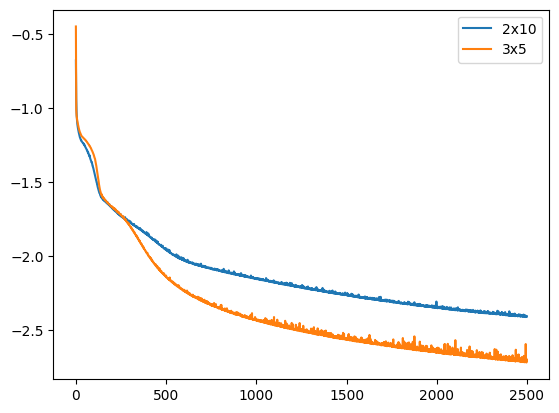

In [31]:
sns.lineplot(np.log10(loss_A), label="2x10")
sns.lineplot(np.log10(loss_B), label="3x5")

**Rings5-Regular**

In [78]:
model_A = MLP(steps=[
    Layer(2, 10), Tanh(),
    Layer(10, 10), Tanh(),
    Layer(10, 5), Softmax()
], optimiser=Adam())

model_B = MLP(steps=[
    Layer(2, 5), Tanh(),
    Layer(5, 5), Tanh(),
    Layer(5, 5), Tanh(),
    Layer(5, 5), Softmax()
], optimiser=Adam())

In [79]:
r5_x_train, r5_y_train, r5_x_test, r5_y_test = get_data_classification("rings5-regular")

In [ ]:
loss_A = model_A.fit(r5_x_train, r5_y_train, epochs=2_500, batch_size=50, verbose=2)
loss_B = model_B.fit(r5_x_train, r5_y_train, epochs=2_500, batch_size=50, verbose=2)

<Axes: >

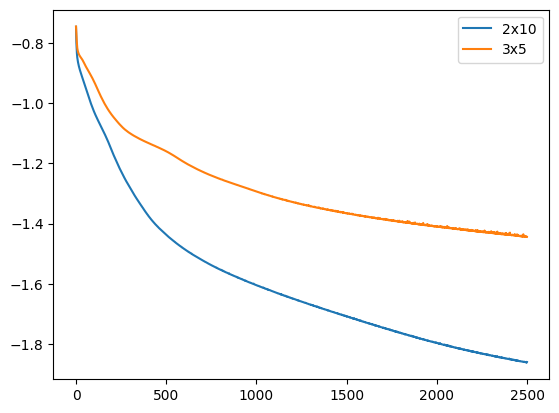

In [81]:
sns.lineplot(np.log10(loss_A), label="2x10")
sns.lineplot(np.log10(loss_B), label="3x5")

**Rings3-Regular**

In [97]:
r3_x_train, r3_y_train, r3_x_test, r3_y_test = get_data_classification("rings3-regular")

In [ ]:
N_runs = 10

loss_A = np.zeros(shape=(N_runs, 2500))
loss_B = np.zeros(shape=(N_runs, 2500))

for i in range(N_runs):
    model_A = MLP(steps=[
        Layer(2, 10), Tanh(),
        Layer(10, 10), Tanh(),
        Layer(10, 3), Softmax()
    ], optimiser=Adam())

    model_B = MLP(steps=[
        Layer(2, 5), Tanh(),
        Layer(5, 5), Tanh(),
        Layer(5, 5), Tanh(),
        Layer(5, 3), Softmax()
    ], optimiser=Adam())

    loss_A[i,:] = model_A.fit(r3_x_train, r3_y_train, epochs=2_500, batch_size=50, verbose=1)
    loss_B[i,:] = model_B.fit(r3_x_train, r3_y_train, epochs=2_500, batch_size=50, verbose=1)

loss_A = np.mean(loss_A, axis=0)
loss_B = np.mean(loss_B, axis=0)

<Axes: >

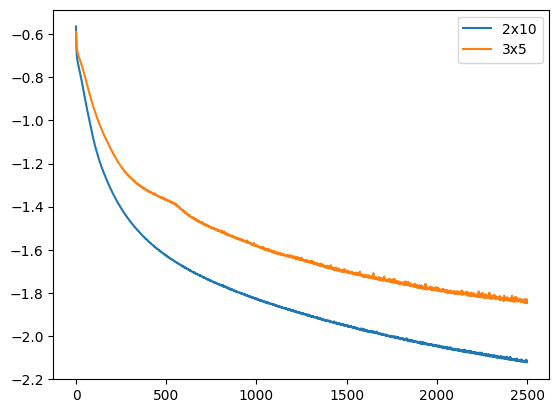

In [99]:
sns.lineplot(np.log10(loss_A), label="2x10")
sns.lineplot(np.log10(loss_B), label="3x5")